In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import torch


from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [3]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

# Cosmo example

In [4]:
omc_range = [0.2, 0.3]
s8_range = [0.6, 1.0]
omb_range = [0.03, 0.06]
h_range = [0.55, 0.85]
cosmoparams = [[0.2, 0.3], [0.6, 1.0], [0.03, 0.06], [0.55, 0.85]]
cosmonames = ['Omega_c', 'sigma_8', 'Omega_b', 'h']
prior = utils.BoxUniform(low=[i[0] for i in cosmoparams], high=[i[1] for i in cosmoparams])


In [5]:
cosmo = torch.tensor(np.load('../data/psdata/traindata/cosmology.npy'))
pk = [np.load('../data/psdata/traindata/pk%04d.npy'%i) for i in range(cosmo.shape[0])]
x = torch.tensor([np.log10(i[1]) for i in pk])
cosmo_test = torch.tensor(np.load('../data/psdata/testdata/cosmology.npy'))
x_test = [np.log10(np.load('../data/psdata/testdata/pk%04d.npy'%i)[1]) for i in range(cosmo_test.shape[0])]


/var/folders/67/7tprz6k979db0qwj44117pkr0001mz/T/ipykernel_51216/3736535508.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x = torch.tensor([np.log10(i[1]) for i in pk])


In [6]:
print(cosmo.shape)
mu, std = cosmo.mean(axis=0), cosmo.std(axis=0)
mux, stdx = x.mean(axis=0), x.std(axis=0)
cosmoz = (cosmo-mu)/std
xz = (x-mux)/stdx

torch.Size([5000, 4])


[]

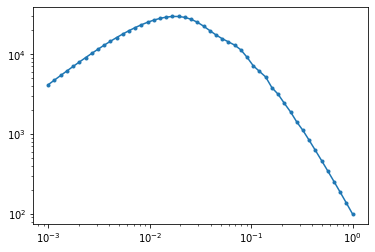

In [7]:
plt.plot(*pk[5], marker='.')
plt.loglog()


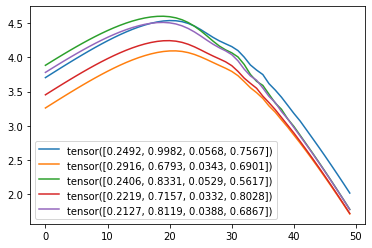

In [8]:
for i in range(5):
    plt.plot(x[i], label=cosmo[i])
plt.legend()

In [9]:
# density_estimator_build_fun = posterior_nn(model='maf', hidden_features=100, num_transforms=5)
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=32, num_transforms=5)
# density_estimator_build_fun = posterior_nn(model='nsf', hidden_features=100, num_transforms=5, num_bins=32)
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(cosmo, xz)

In [10]:
density_estimator = inference.train(show_train_summary=True)

Neural network successfully converged after 197 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 197
        Best validation performance: 18.2031
        -------------------------
        


In [11]:
posterior = inference.build_posterior(density_estimator)

### Check testdata

154 tensor([0.2154, 0.9601, 0.0555, 0.7565])


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

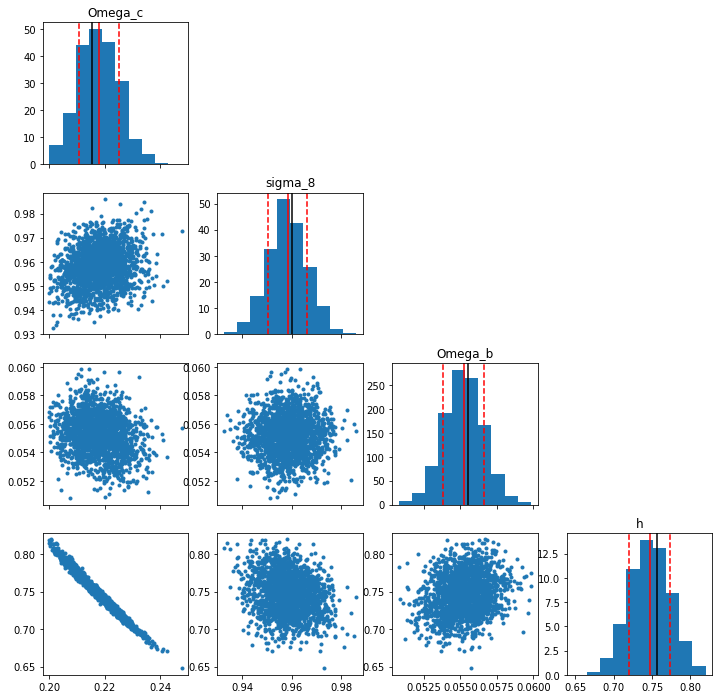

In [12]:
ndim = 4
ii = np.random.randint(0, high=cosmo_test.shape[0])
print(ii, cosmo_test[ii])
posterior_samples = posterior.sample((2000,), x=(torch.tensor(x_test[ii])-mux)/stdx).numpy()

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
    axar[i, i].hist(posterior_samples[:, i], density=True);
    axar[i, i].axvline(posterior_samples[:, i].mean(), color='r');
    axar[i, i].axvline(posterior_samples[:, i].mean()+posterior_samples[:, i].std(), color='r', ls="--");
    axar[i, i].axvline(posterior_samples[:, i].mean()-posterior_samples[:, i].std(), color='r', ls="--");
    axar[i, i].axvline(cosmo_test[ii][i], color='k')
    for j in range(0, i):
        axar[i, j].plot(posterior_samples[:, j], posterior_samples[:, i], '.')
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): axar[i, i].set_title(cosmonames[i])